In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
train_data = pd.read_csv("train_data.csv", encoding ='utf8')
target = pd.read_csv('train_target.csv', encoding ='utf8')
y = target.gender

In [3]:
from scipy import sparse

subreddits = train_data.subreddit.unique()
subreddits_map = pd.Series(index=subreddits, data=arange(subreddits.shape[0]))

def extract_features(group):
    group_subreddits = group['subreddit']
    group_subreddits = group_subreddits[group_subreddits.isin(subreddits_map.index)].values
    idxs = subreddits_map.loc[group_subreddits].values
    v = sparse.dok_matrix((1, subreddits.shape[0]))
    for idx in idxs:
        if not np.isnan(idx):
            v[0, idx] = 1
    return v.tocsr()

features_dict = {}
for author, group in train_data.groupby('author'):
    features_dict[author] = extract_features(group)

In [4]:
def extract_features_frac(group):
    n_author = len(group) #total number of messages written by the same author
    group_subreddits = group['subreddit']
    group_subreddits = group_subreddits[group_subreddits.isin(subreddits_map.index)].values 
    gs = pd.Series(data = group_subreddits)
    idxs = subreddits_map.loc[group_subreddits].values 
    v = sparse.dok_matrix((1, subreddits.shape[0])) 
    for idx in idxs:
        if not np.isnan(idx):
            n_sub = len(gs.loc[gs == subreddits_map.index[idx]]) #number of messages written by the same author in the same subreddit
            v[0, idx] = n_sub / n_author #in this way every row is normalized to 1
    return v.tocsr()

features_dict_frac = {}

for author, group in train_data.groupby('author'):
    features_dict_frac[author] = extract_features_frac(group)

In [5]:
def extract_text(group):
    group_text = group['body'].astype(str).values #contains all messages from the same author
    return " ".join(group_text)

from collections import OrderedDict

text_dict = {}

for author, group in train_data.groupby('author'):
    text_dict[author] = extract_text(group)

ord_text_dict = OrderedDict((author,text_dict[author]) for author in target.author)

corpus = list(ord_text_dict.values()) 

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.base import BaseEstimator, TransformerMixin 

pattern ='(?u)\\b[A-Za-z]{3,}' #defining the allowed characters and stop words
stop_words = set(list(ENGLISH_STOP_WORDS) + ['http', 'https'])

class Extractor(BaseEstimator, TransformerMixin):
    def __init__(self, frac = False, min_df= 0.05, max_df=.5): #avoid *args and **kwargs
        self.frac = frac
        self.min_df = min_df  #tfidf parameters
        self.max_df = max_df  ##
    def fit(self, data, y = None):
        return self
    def transform(self, data, target):
        features_dict = {}
        text_dict = {}

        for author, group in data.groupby('author'): #text extraction
            text_dict[author] = extract_text(group)

        ord_text_dict = OrderedDict((author,text_dict[author]) for author in target.author)
        corpus = list(ord_text_dict.values()) 
        tfidf = TfidfVectorizer(ngram_range = (1,2), stop_words=stop_words, min_df= self.min_df, max_df= self.max_df, token_pattern=pattern)
        T = tfidf.fit_transform(corpus)

        if self.frac: #frac argument decides subreddit vectorization procedure
            for author, group in train_data.groupby('author'):
                features_dict[author] = extract_features_frac(group)

            X = sparse.vstack([features_dict[author] for author in target.author])

        else:
            for author, group in train_data.groupby('author'):
                features_dict[author] = extract_features(group)

            X = sparse.vstack([features_dict[author] for author in target.author])

        return sparse.hstack([X,T]).tocsr() #outputs an unique matrix with all features

In [7]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [25]:
def visualizer(pred,y):
    fpr, tpr, thresholds = metrics.roc_curve(y,pred)
    roc_auc = metrics.auc(fpr,tpr)
    display = metrics.RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=roc_auc,estimator_name='Random Forest')
    display.plot()
    plt.show()

In [9]:
extractor = Extractor()
XT = extractor.transform(train_data, target)

In [10]:
frac_extractor = Extractor(frac=True, max_df=.4)
XfT = frac_extractor.transform(train_data, target)

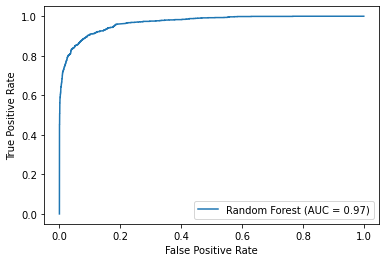

In [26]:
clf = RandomForestClassifier(n_estimators = 600, max_depth = 60, max_leaf_nodes=70, bootstrap=False, n_jobs=-1)
clf.fit(XT,y)
pred = clf.predict_proba(XT)[:,1]
visualizer(pred,y)

In [18]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, XT, y, scoring='roc_auc',cv=5, n_jobs=-1)
print(np.mean(scores))

0.8680965008907723


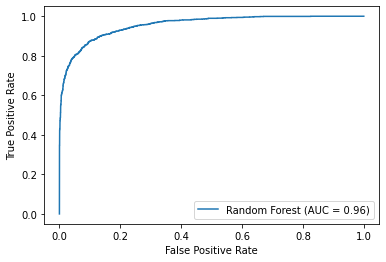

In [55]:
frac_clf = RandomForestClassifier(n_estimators=800, max_depth=40, max_leaf_nodes=50, bootstrap=True, n_jobs=-1)
frac_clf.fit(XfT,y)
frac_pred=frac_clf.predict_proba(XfT)[:,1]
visualizer(frac_pred, y)

In [56]:
frac_scores = cross_val_score(frac_clf, XfT,y, scoring='roc_auc',cv=5,n_jobs=-1)
print(np.mean(frac_scores))

0.8676195934526495


In [57]:
np.std(frac_scores)

0.012027940538559417

In [ ]:
from sklearn.model_selection import GridSearchCV

frac_grid = {'n_estimators':[600,700], 'max_leaf_nodes':[75,80,90], 'max_depth':[30,40,50]}
frac_GSCV = GridSearchCV(frac_clf, frac_grid, scoring='roc_auc',cv=5,n_jobs=-1,return_train_score=True)
frac_GSCV.fit(XfT,y)
print(frac_GSCV.best_params_)
frac_res = frac_GSCV.cv_results_
for mean, params in zip(frac_res['mean_test_score'], frac_res['params']):
    print(mean,params)